# Check Medcam Results

In [7]:
from glob import glob
import nibabel as nib

path = 'attention_maps/layer1/*'
files = glob(path)

att_map = nib.load(files[0])

In [9]:
att_map.get_fdata().shape

(24, 24, 48)

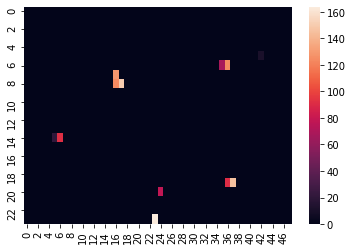

In [11]:
import seaborn as sns
sns.heatmap(att_map.get_fdata()[12])

## TorchIO

In [11]:
import torchio as tio
import matplotlib.pyplot as plt

In [16]:
# %load src/dataloader.py
from glob import glob
import numpy as np
import pandas as pd
from scipy.ndimage import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

import nibabel as nib

import torch
from torch.utils.data import Dataset, DataLoader
import torchio as tio

class MyDataset(Dataset):
    def __init__(self, task_type, test_size=0.2, test=False, scaler='minmax',
                path='../../brainmask_tlrc/*.npy', fold=None,
                augment=None):

        self.scaler = scaler
        self.augment = augment

        RANDOM_STATE = 42
        np.random.seed(RANDOM_STATE)

        data_files = glob(path)
        data_files.sort()
            
        label_file = pd.read_csv('../rsc/age_ixidlbsoas13.csv', index_col=0)
        
        idx = label_file[label_file['used'] == 1].index
        data_files = np.array(glob('../../brainmask_tlrc/*.npy'))
        data_files.sort()
        data_files = data_files[idx].tolist()

        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))

        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname = [data_files[i] for i in shuffled_index[-test_num:]]
        

        if test and fold is None:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file[task_type].values[shuffled_index[-test_num:]]
            self.fname = label_file['id'].values[shuffled_index[-test_num:]]

        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file[task_type].values[shuffled_index[:train_num]]
            self.fname = label_file['id'].values[shuffled_index[:train_num]]
                
            if fold is not None:
                kfold = KFold(10)
                for i, idx in enumerate(kfold.split(self.label_file)):
                    
                    if i == fold:

                        if test:
                            self.data_files = np.array(self.data_files)[idx[1]]
                            self.label_file = self.label_file[idx[1]]

                        else:
                            self.data_files = np.array(self.data_files)[idx[0]]
                            self.label_file = self.label_file[idx[0]]
                        break
        
        self.transform = tio.OneOf({
            tio.RandomAffine(),
            tio.RandomFlip(axes=['left-right']),
            tio.RandomElasticDeformation()
        })
                        

    def __getitem__(self, idx):
        
        if self.scaler == 'minmax':
            x = np.load(self.data_files[idx])
            x = MinMaxScaler().fit_transform(x.reshape(-1, 1)).reshape(141, 172, 110)

        else:
            x = np.load(self.data_files[idx])

        if self.augment:
            # x = torch.tensor(shift(x, shift=[1, 1, 1]))[None, :, :].float()
            x = self.transform(x[None, ...])

        else:
            x = torch.tensor(x)[None, :, :].float()
            
        y = torch.tensor(self.label_file[idx]).float()
        
        return x, y

    def __len__(self):
        return len(self.data_files)


In [17]:
train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)
aug_dset = MyDataset(task_type='age', augment=True)
train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

In [50]:
transform = tio.OneOf({
    tio.RandomAffine(),
    tio.RandomFlip(axes=['left-right'])
})

In [51]:
transform_sample = transform(sample)

In [52]:
aug_dset[0]

(array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0.

In [18]:
sample = train_dset[0][0]

In [18]:
random_affine = tio.RandomAffine()
slice_affine = random_affine(sample)

Init signature:   
tio.RandomElasticDeformation(   
    num_control_points: Union[int, Tuple[int, int, int]] = 7,   
    max_displacement: Union[float, Tuple[float, float, float]] = 7.5,   
    locked_borders: int = 2,   
    image_interpolation: str = 'linear',   
    **kwargs,   
)   

In [23]:
random_elastic = tio.RandomElasticDeformation()
elastic_sample = random_elastic(sample)

In [20]:
type(sample)

torch.Tensor

In [21]:
type(transform_sample)

NameError: name 'transform_sample' is not defined

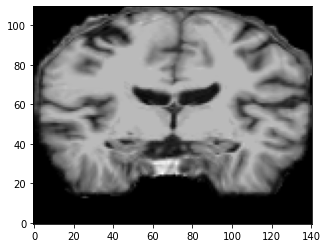

In [27]:
fig, ax = plt.subplots()
ax.imshow(sample[0][:, 86, :].T, cmap="gray", origin="lower")

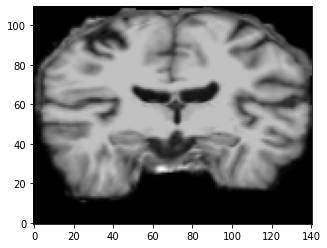

In [28]:
fig, ax = plt.subplots()
ax.imshow(elastic_sample[0][:, 86, :].T, cmap="gray", origin="lower")

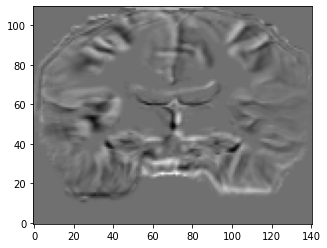

In [29]:
fig, ax = plt.subplots()
ax.imshow((sample - elastic_sample)[0][:, 86, :].T, cmap="gray", origin="lower")

## Retouch labels - with oasis3 3T removed

In [4]:
import pandas as pd
changed = pd.read_csv('../../brainmask_nii/age_ixi_and_oasis.csv', index_col=0)
changed.head()

,id,age,age_zscored,src,binary
0,IXI002-Guys-0828-T1,35,-1.139772,IXI,0
1,IXI016-Guys-0697-T1,55,-0.063921,IXI,0
2,IXI017-Guys-0698-T1,29,-1.462527,IXI,0
3,IXI019-Guys-0702-T1,58,0.097456,IXI,0
4,IXI020-Guys-0700-T1,39,-0.924602,IXI,0


In [25]:
changed[changed['id'].apply(lambda x: x[:3] == 'sub')]

SyntaxError: invalid syntax (<ipython-input-25-c057994db34b>, line 1)

In [13]:
changed['id'] = changed['id'].apply(lambda x: x.split('.')[0])

In [21]:
changed.shape

(1181, 5)

In [15]:
len(set(label_file['id'].values) - set(changed['id'].values))

460

In [10]:
label_file = pd.read_csv('../rsc/age_ixioasdlbs.csv', index_col=0)
label_file[label_file['src']!='IXI']

,id,age,src,binary
312,PAL1003_mpr_wave1_orig,54,Dallas,NaN
313,PAL1007_mpr_wave1_orig,72,Dallas,NaN
314,PAL1008_mpr_wave1_orig,22,Dallas,NaN
315,PAL1011_mpr_wave1_orig,70,Dallas,NaN
316,PAL1013_mpr_wave1_orig,21,Dallas,NaN
...,...,...,...,...
1422,sub-OAS31164_ses-d0069_run-02_T1w,71,Oasis3,1.0
1423,sub-OAS31165_ses-d0426_run-02_T1w,19,Oasis3,0.0
1424,sub-OAS31167_ses-d0064_run-03_T1w,61,Oasis3,1.0
1425,sub-OAS31168_ses-d0148_run-02_T1w,61,Oasis3,1.0


In [64]:
label_file.loc[label_file['id'].apply(lambda x: x in set(changed['id'].values)), 'used'] = 1

In [66]:
label_file.to_csv('../rsc/age_ixidlbsoas13.csv')

In [60]:
np.random.choice(train_dset.data_files, 10)

array(['../../brainmask_tlrc\\PAL1439_mpr_wave1_orig-brainmask_tlrc.npy',
       '../../brainmask_tlrc\\IXI285-Guys-0857-T1-brainmask_tlrc.npy',
       '../../brainmask_tlrc\\IXI073-Guys-0755-T1-brainmask_tlrc.npy',
       '../../brainmask_tlrc\\PAL2231_mpr_wave1_new-brainmask_tlrc.npy',
       '../../brainmask_tlrc\\IXI616-Guys-1092-T1-brainmask_tlrc.npy',
       '../../brainmask_tlrc\\IXI266-Guys-0853-T1-brainmask_tlrc.npy',
       '../../brainmask_tlrc\\IXI075-Guys-0754-T1-brainmask_tlrc.npy',
       '../../brainmask_tlrc\\reconV6_OAS1_0375_MR1-brainmask_tlrc.npy',
       '../../brainmask_tlrc\\IXI222-Guys-0819-T1-brainmask_tlrc.npy',
       '../../brainmask_tlrc\\PAL2248_mpr_wave1_orig-brainmask_tlrc.npy'],
      dtype='<U62')

In [18]:
train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

In [20]:
len(train_dset)

945

In [65]:
train_dset_augment = MyDataset(task_type='age', augment=True)

In [66]:
train_dset_augment[0]

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., -0.,  ..., 0., -0., -0.],
           [0., 0., 0.,  ..., 0., 0., -0.],
           ...,
           [0., -0., -0.,  ..., -0., -0., -0.],
           [0., -0., -0.,  ..., -0., -0., -0.],
           [0., -0., -0.,  ..., 0., 0., -0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., -0., -0., -0.],
           [0., -0., 0.,  ..., -0., -0., -0.],
           ...,
           [0., 0., -0.,  ..., -0., -0., 0.],
           [0., 0., 0.,  ..., -0., -0., -0.],
           [0., 0., 0.,  ..., 0., 0., -0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., -0., -0., -0.],
           [0., -0., -0.,  ..., 

In [68]:
sample = train_dset[1][0][0]

In [69]:
from torchvision.transforms.functional import affine
from torchvision.transforms import RandomAffine, RandomVerticalFlip, RandomHorizontalFlip

In [70]:
from scipy.ndimage import shift

In [24]:
sample_shift1 = shift(sample, shift=[1, 1, 1])

In [34]:
sample_vert = RandomVerticalFlip(p=0.5)(sample)

In [37]:
sample_hor = RandomHorizontalFlip(p=0.5)(sample)

In [71]:
sample_lr = torch.fliplr(sample)

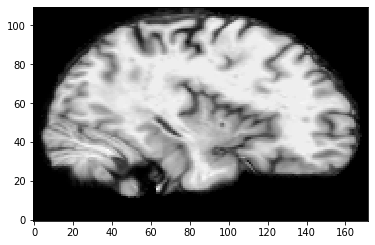

In [26]:
fig, ax = plt.subplots()
ax.imshow(sample[36, :, :].T, cmap="gray", origin="lower")

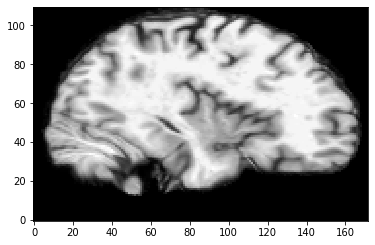

In [25]:
fig, ax = plt.subplots()
ax.imshow(sample_shift1[36, :, :].T, cmap="gray", origin="lower")

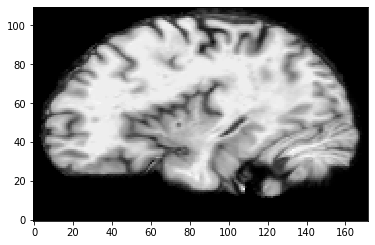

In [35]:
fig, ax = plt.subplots()
ax.imshow(sample_vert[36, :, :].T, cmap="gray", origin="lower")

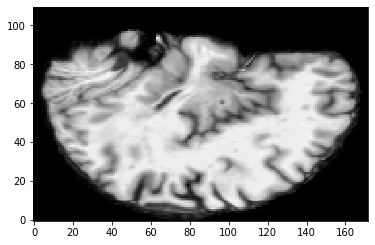

In [38]:
fig, ax = plt.subplots()
ax.imshow(sample_hor[36, :, :].T, cmap="gray", origin="lower")

In [75]:
import matplotlib.pyplot as plt

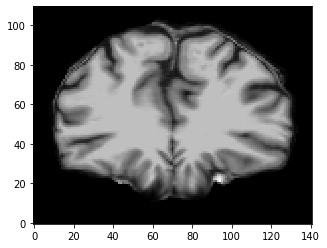

In [76]:
fig, ax = plt.subplots()
ax.imshow(sample_lr[:, 36, :].T, cmap="gray", origin="lower")

In [29]:
sample_shift1.shape

(141, 172, 110)

In [30]:
sample.shape

torch.Size([141, 172, 110])

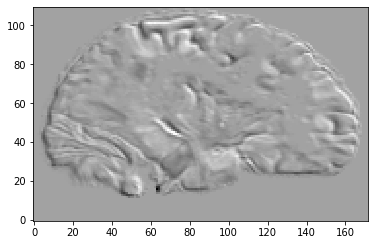

In [31]:
fig, ax = plt.subplots()
ax.imshow((torch.tensor(sample_shift1) - sample)[36, :, :].T, cmap="gray", origin="lower")

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


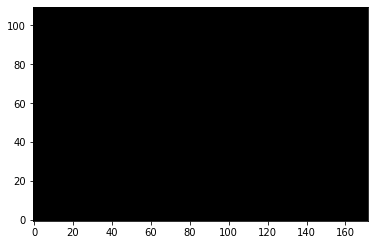

In [32]:
fig, ax = plt.subplots()
ax.imshow((torch.tensor(sample) - sample)[36, :, :].T, cmap="gray", origin="lower")

In [23]:
import matplotlib.pyplot as plt

In [15]:
RandomAffine(degrees=1, translate=[1, 1, 1])

AssertionError: translate should be a list or tuple and it must be of length 2.

In [1]:
import numpy as np
from src.architectures.dinsdale import *
from torchsummary import summary
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
model = Dinsdale(1, 1)

# model.to(device)
summary(model, input_size=(1, 96, 96, 96))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [3]:
x = Tensor(np.zeros((2, 1, 96, 96, 96))).to(device)

In [4]:
outputs = model.forward(x)

In [6]:
outputs.shape

torch.Size([2, 1])

In [1]:
from src.architectures.inception_copy import *
import numpy as np
from src.architectures.inception import *
from torchsummary import summary
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
model = inception_v3()

G:\내 드라이브\brain_data\workspace\3d_brain\src\architectures\inception_copy.py:81: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [4]:
model

Inception3(
  (Conv3d_1a_3x3): BasicConv3d(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False)
    (bn): BatchNorm3d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv3d_2a_3x3): BasicConv3d(
    (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv3d_2b_3x3): BasicConv3d(
    (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv3d_3b_1x1): BasicConv3d(
    (conv): Conv3d(64, 80, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv3d_4a_3x3): BasicConv3d(
    (conv): Conv3d(80, 19

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, input_size=(1, 96, 96, 96))

RuntimeError: expected stride to be a single integer value or a list of 2 values to match the convolution dimensions, but got stride=[1, 1, 1]

In [4]:
x = Tensor(np.zeros((2, 1, 96, 96, 96))).to(device)

In [5]:
outputs = model.forward(x)

In [6]:
outputs.shape

torch.Size([2, 128, 96, 96, 96])

In [1]:
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from src.run import run
from src.dataloader import MyDataset
from src.evaluate import eval, loss_plot, result_plot
from src.model.vanilla import Vanilla3d

model_list = {
    'vanilla': Vanilla3d
}

optimizer_list = {
    'adam': optim.Adam
}

loss_list = {
    'mse': nn.MSELoss,
    'bce': nn.BCELoss
}

scheduler_list = {
    'cosine': optim.lr_scheduler.CosineAnnealingLR
}

In [2]:
class Args:
    
    def __init__(self, task_type='binary', batch_size=8):
        
        self.task_type = task_type
        self.batch_size = batch_size

In [3]:
args = Args()

In [4]:
# 00. Load Data
train_dset = MyDataset(args.task_type)
test_dset = MyDataset(args.task_type, test=True)

train_loader = DataLoader(train_dset, batch_size=args.batch_size)
test_loader = DataLoader(test_dset, batch_size=args.batch_size)

In [9]:
import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [139]:
epi_img_data = x[0]

In [140]:
epi_img_data = epi_img_data.squeeze()

In [141]:
epi_img_data.shape

torch.Size([64, 64, 64])

In [27]:
from glob import glob
import nibabel as nib
idx = 1000
data_files = glob('../../brainmask_nii/*.nii')
x = nib.load(data_files[idx]).get_fdata()

(array([1.510157e+07, 1.099420e+05, 1.296440e+05, 1.715710e+05,
        2.238530e+05, 2.671790e+05, 1.878920e+05, 1.399780e+05,
        1.476650e+05, 1.468330e+05, 1.428590e+05, 5.612000e+03,
        7.970000e+02, 4.070000e+02, 3.170000e+02, 2.610000e+02,
        2.390000e+02, 1.930000e+02, 2.180000e+02, 1.860000e+02]),
 array([  0. ,  10.8,  21.6,  32.4,  43.2,  54. ,  64.8,  75.6,  86.4,
         97.2, 108. , 118.8, 129.6, 140.4, 151.2, 162. , 172.8, 183.6,
        194.4, 205.2, 216. ]),
 <a list of 20 Patch objects>)

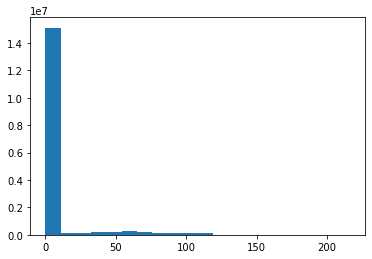

In [28]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(x.reshape(-1), 20)

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x.reshape(-1, 1))
x_scaled = scaler.transform(x.reshape(-1, 1))

(array([1.510157e+07, 1.099420e+05, 1.296440e+05, 1.715710e+05,
        2.238530e+05, 2.671790e+05, 1.878920e+05, 1.399780e+05,
        1.476650e+05, 1.468330e+05, 1.428590e+05, 5.612000e+03,
        7.970000e+02, 4.070000e+02, 3.170000e+02, 2.610000e+02,
        2.390000e+02, 1.930000e+02, 2.180000e+02, 1.860000e+02]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

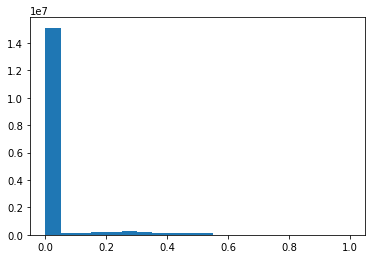

In [32]:
plt.hist(x_scaled.reshape(-1), 20)

In [ ]:
# 01. Define Model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')
model = model_list[args.model](args.task_type).to(device)

In [ ]:
# 02. Setups
optimizer = optimizer_list[args.optimizer](model.parameters(),
                                           lr=args.learning_rate)
scheduler = scheduler_list[args.scheduler](optimizer, len(train_loader), eta_min=0) if args.scheduler else None
loss_fn = loss_list[args.loss_function]()
EPOCHS = range(args.epochs)

In [ ]:
# 03. Run
summary = SummaryWriter(f'./tensorboard/{datetime.now().strftime("%Y-%m-%d_%H%M")}') if args.save else None
fname = f'{datetime.now().strftime("%Y-%m-%d_%H%M-")}' if args.save else None
model, losses = run(model=model, epochs=EPOCHS, train_loader=train_loader, test_loader=test_loader,
                    optimizer=optimizer, loss_fn=loss_fn, device=device,
                    summary=summary, scheduler=scheduler, verbose=True)

if args.save:
    torch.save(model, f"./models/{fname}_model.pth")

In [ ]:
# 04. Evaluate
# 04-1. Loss Plot
#loss_plot(*losses, EPOCHS, args.loss_function)

# 04-2. Result Plot
train_true, train_pred = eval(model=model, loader=train_loader, device=device)
result_plot(task_type=args.task_type, trues=train_true, preds=train_pred, title='Train', fname=fname)

test_true, test_pred = eval(model=model, loader=test_loader, device=device)
result_plot(task_type=args.task_type, trues=test_true, preds=test_pred, title='Test', fname=fname)

### Debugging Holygrail

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import resample_img
from nilearn.image import new_img_like, load_img, clean_img, crop_img
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
import glob

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from torchsummary import summary

from IPython import display
%matplotlib inline

In [2]:
def show_slice(data, idx=0):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    im=axs[0].imshow(data[idx,:,:])
    fig.colorbar(im, ax=axs[0])
    
    im=axs[1].imshow(data[:,idx,:])
    fig.colorbar(im, ax=axs[1])
    
    im=axs[2].imshow(data[:,:,idx])
    fig.colorbar(im, ax=axs[2])
    
    plt.suptitle('Slice {}, dim={}x{}x{}'.format(idx, *data.shape))
    plt.show()

In [3]:
def process_scans(rsc='../../brainmask_nii/',resample=3, crop=True,
                 subsample=None):
    
    df = pd.read_csv('../rsc//age_ixi_and_oasis.csv')
    files = df['id']
    
    X = []
    y = df['binary'].values
    yage = df['age'].values
    for fname in tqdm(files):
        
        try: 
            tmp = nib.load(rsc+fname+'-brainmask.nii')
        except:
            tmp = nib.load(rsc+fname+'.nii-brainmask.nii')
            
        dtmp = resample_img(tmp, target_affine=np.eye(3)*resample*1.0,
                            interpolation='nearest')
        if crop:
            
            # we know that in our sample 53 70 58 are the largest
            # brains, so we crop first and then embed
            
            tc = crop_img(dtmp).get_fdata()
            te = np.zeros((53,70,58))
            
            d1 = np.floor((53 - tc.shape[0]) / 2).astype(np.int16)
            d2 = np.floor((70 - tc.shape[1]) / 2).astype(np.int16)
            d3 = np.floor((58 - tc.shape[2]) / 2).astype(np.int16)
            
            te[d1:d1+tc.shape[0],
               d2:d2+tc.shape[1],
               d3:d3+tc.shape[2]] = tc
            X.append(te)
            
        else:
            
            X.append(dtmp.get_fdata()[:86,:86,:86])
            
    return X, y, yage

X, y, yage = process_scans()
# X = np.array(X)
# np.save('X_crop.npy', X)
# np.save('y.npy', y)
# np.save('yage.npy', yage)

  1%|█                                                                               | 15/1179 [00:03<04:54,  3.95it/s]


KeyboardInterrupt: 

In [4]:
X = np.load('X_crop.npy', allow_pickle=True)
y = np.load('yage.npy')

In [5]:
for i in range(len(X)):
    tmp = X[i].reshape(-1)
    mitmp = np.min(tmp)
    matmp = np.max(tmp)
    X[i]= (X[i]-mitmp)/(matmp-mitmp)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

del X, y

In [7]:
# since X.shape is (1187*.8, 53, 70, 58) and we need to add channel axis, which is 1
X_train = torch.from_numpy(X_train).float().view(X_train.shape[0], 1, 53, 70, 58)
X_test  = torch.from_numpy(X_test).float().view(X_test.shape[0], 1, 53, 70, 58)

y_train = torch.from_numpy(y_train).float()
y_test  = torch.from_numpy(y_test).float()

In [8]:
batch_size = 16

trn_ds = torch.utils.data.TensorDataset(X_train, y_train)
tst_ds = torch.utils.data.TensorDataset(X_test, y_test)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=batch_size, shuffle=False)

del X_train, X_test

In [9]:
num_classes = 1

# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(1, 8)
        self.conv_layer2 = self._conv_layer_set(8, 16)
        self.conv_layer3 = self._conv_layer_set(16, 32)
        self.conv_layer4 = self._conv_layer_set(32, 64)
        
        self.fc1 = nn.Linear(2304, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
        
        
    def _conv_layer_set(self, in_c, out_c):
        
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(out_c),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )
        
        return conv_layer
    
    
    def _conv_layer_set2(self, in_c, out_c):
        
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c,  out_c, kernel_size=(2,2,2), padding=1),
            nn.Conv3d(out_c, out_c, kernel_size=(2,2,2), padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )
        
        return conv_layer

    
    def forward(self, x):
        
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.drop(out)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.drop(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        
        return out

In [10]:
#Definition of hyperparameters
n_iters = 1000
num_epochs = n_iters / (len(trn_dl) / batch_size)
num_epochs = int(num_epochs)
device = torch.device("cuda:0") # use cuda device 0

print('running',num_epochs,'on',device)

# Create CNN
model = CNNModel()
model.to(device)
print(summary(model, input_size=(1,53,70,58)))

# # Cross Entropy Loss 
# error = nn.CrossEntropyLoss()

# MSR Loss
error = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.00005
optimizer = torch.optim.SGD(model.parameters(),
                             lr=learning_rate,
                             weight_decay=0.0005,
                             momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2, last_epoch=-1) 

running 271 on cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 53, 70, 58]             224
       BatchNorm3d-2        [-1, 8, 53, 70, 58]              16
              ReLU-3        [-1, 8, 53, 70, 58]               0
         MaxPool3d-4        [-1, 8, 26, 35, 29]               0
            Conv3d-5       [-1, 16, 26, 35, 29]           3,472
       BatchNorm3d-6       [-1, 16, 26, 35, 29]              32
              ReLU-7       [-1, 16, 26, 35, 29]               0
         MaxPool3d-8       [-1, 16, 13, 17, 14]               0
            Conv3d-9       [-1, 32, 13, 17, 14]          13,856
      BatchNorm3d-10       [-1, 32, 13, 17, 14]              64
             ReLU-11       [-1, 32, 13, 17, 14]               0
        MaxPool3d-12          [-1, 32, 6, 8, 7]               0
           Conv3d-13          [-1, 64, 6, 8, 7]          55,360
      BatchNorm3d

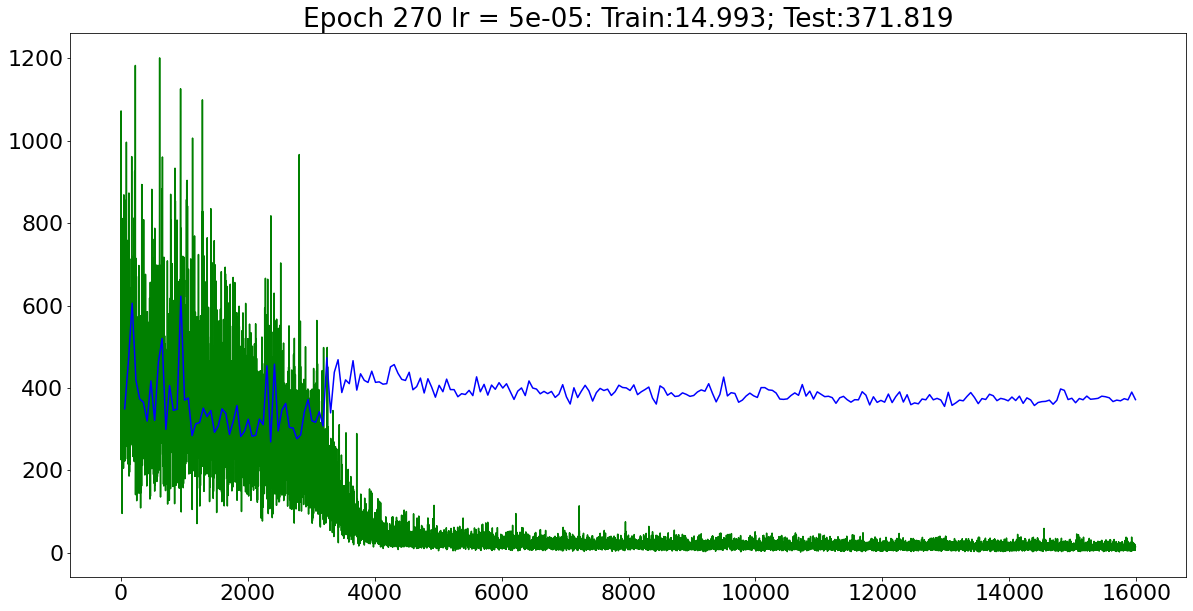

In [12]:
torch.cuda.empty_cache()

plt.figure(figsize=(20,10))
axes = plt.gca() # get current axis?
axes.set_ylim([0,1000])
plt.grid(True)
plt.rcParams.update({'font.size': 22})

# CNN model training
count = 0
loss_list = []
count_list=[]
batch_accuracy_list = []
accuracy_list = []
for epoch in range(num_epochs):
    
    batch_accuracy = 0
    batch_total = 0
    #scheduler.step()
    for i, (train, labels) in enumerate(trn_dl):  
        
        #train = Variable(images.view(batch_size,1,86,86,86))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train.to(device)).squeeze()
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels.to(device))
        loss_list.append(loss.data)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        plt.cla()
        plt.plot(loss_list,'g-')
        display.display(plt.gcf()) # get current figure
        display.clear_output(wait=True) 

        # Total number of labels
        batch_total += 1
        batch_accuracy += loss.data
        
    batch_accuracy_list.append(batch_accuracy/batch_total)
        
#         # Get predictions from the maximum value
#         predicted = torch.max(outputs.data, 1)[1]

#         # Total number of labels
#         batch_total += len(labels)
#         batch_accuracy += (predicted == labels.to(device)).sum().data
    
#     batch_accuracy_list.append(100*batch_accuracy/batch_total)

    with torch.no_grad():

        # below code is for classification I guess
#     correct = 0
#     total = 0
#     # Iterate through test dataset
#     for test, labels in test_loader:

#         #test = Variable(images)
#         # Forward propagation
#         outputs = model(test.to(device))

#         # Get predictions from the maximum value
#         predicted = torch.max(outputs.data, 1)[1]

#         # Total number of labels
#         total += len(labels)
#         correct += (predicted == labels.to(device)).sum().data

#     accuracy = 100 * correct / float(total)
#     plt.title('Epoch {:}: Train:{:.3f}; Test:{:.3f}'.format(
#               epoch,100*batch_accuracy/batch_total,accuracy))
#     accuracy_list.append(accuracy)

        accuracy = 0
        total = 0
        for test, labels in tst_dl:
            
            # Forward propagation
            outputs = model(test.to(device)).squeeze()
            accuracy += error(outputs,labels.to(device))
            total +=1
            
        count_list.append(count)
        accuracy_list.append(accuracy)
        
    plt.plot(np.array(count_list), np.array(accuracy_list)/total, 'b')
    plt.title('Epoch {:} lr = {:}: Train:{:.3f}; Test:{:.3f}'.format(
                epoch,
                learning_rate,#scheduler.get_lr()[0],
                batch_accuracy/batch_total,
                accuracy/total))
    
    display.display(plt.gcf())
    display.clear_output(wait=True) 

### Picture Debug

Deal with differences between IXI & Oasis1 & Oasis3

In [6]:
import pandas as pd

y = pd.read_csv('../rsc/age_ixi_and_oasis.csv')

In [7]:
from src.dataloader import *

In [10]:
data_files = glob('../../brainmask_nii/*.nii')
data_files.sort()

In [24]:
i = 1

ixi_idx = 0
oas1_idx = 314
oas3_idx = 800

In [25]:
ixi = data_files[ixi_idx+i]
oas1 = data_files[oas1_idx+i]
oas3 = data_files[oas3_idx+i]

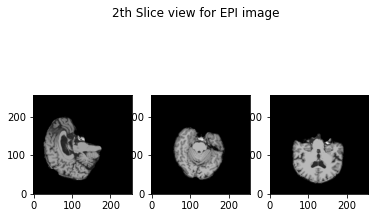

In [26]:
ixi = SliceViewer(nib.load(ixi).get_fdata())
ixi.triple_view()

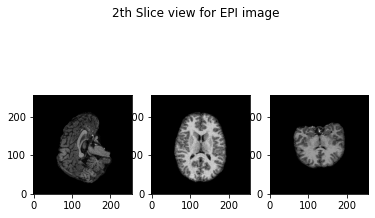

In [27]:
oas1 = SliceViewer(nib.load(oas1).get_fdata())
oas1.triple_view()

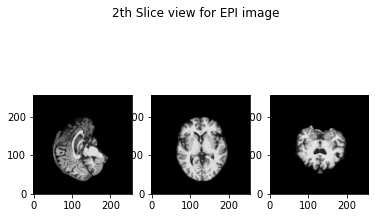

In [28]:
oas3 = SliceViewer(nib.load(oas3).get_fdata())
oas3.triple_view()

# With registered IXIs(312)

## Preprocess: resize down to the maximum voxel

Finding biggest brain - but it'll be same since they're registered...but just to check

In [4]:
import numpy as np
from glob import glob
from itertools import groupby

from tqdm.notebook import tqdm

In [5]:
data_files_reg = glob('../../brainmask_reg/*.npy')

In [8]:
idxs = [[256, 0] for _ in range(3)]
for sample in tqdm(data_files_reg):
    
    maxs = [[] for _ in range(3)]
    sample = np.load(sample)
    for i in range(256):
        
        maxs[0].append(sample[i, :, :].max())
        maxs[1].append(sample[:, i, :].max())
        maxs[2].append(sample[:, :, i].max())
        
    
    for i in range(3):
        reference = list(filter(lambda x: x > 1, [len(list(g)) for k, g in groupby(maxs[i])]))
        idxs[i][0] = min(idxs[i][0], reference[0])
        idxs[i][1] = max(idxs[i][1], reference[-1])

In [9]:
idxs

[[55, 55], [44, 70], [20, 63]]

In [10]:
idxs_correction = [[_[0], 256 - _[1]]for _ in idxs]
idxs_correction

[[55, 201], [44, 186], [20, 193]]

53 70 58

In [11]:
idxs_subtraction = [_[1] - _[0] for _ in idxs_correction]

In [12]:
idxs_subtraction

[146, 142, 173]

## 3D Resnet

In [7]:
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F


def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=400):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [4]:
class Option:
    
    def __init__(self, model_depth=10,
                n_classes=1,
                n_input_channels=1,
                conv1_t_size=3,
                conv1_t_stride=1,
                no_max_pool=False,
                resnet_widen_factor=1.0
                ):
        
        self.model_depth = model_depth
        self.n_classes = n_classes
        self.n_input_channels = n_input_channels
        self.conv1_t_size = conv1_t_size
        self.conv1_t_stride = conv1_t_stride
        self.no_max_pool = no_max_pool
        self.resnet_widen_factor = resnet_widen_factor

opt = Option()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = generate_model(model_depth=opt.model_depth,
                              n_classes=opt.n_classes,
                              n_input_channels=opt.n_input_channels,
#                               shortcut_type=opt.resnet_shortcut,
                              conv1_t_size=opt.conv1_t_size,
                              conv1_t_stride=opt.conv1_t_stride,
                              no_max_pool=opt.no_max_pool,
                              widen_factor=opt.resnet_widen_factor)
model.to(device)

summary(model, input_size=(1, 96, 96, 96))

In [17]:
task_type = 'age'
resize = True
scheduler = False

In [18]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
summary = SummaryWriter(f'./tensorboard/{datetime.now().strftime("%Y-%m-%d_%H%M")}')

In [1]:
from glob import glob
data_files = glob('../../brainmask_nii/*.nii')
data_files.sort()
data_files

['../../brainmask_nii\\IXI002-Guys-0828-T1-brainmask.nii',
 '../../brainmask_nii\\IXI016-Guys-0697-T1-brainmask.nii',
 '../../brainmask_nii\\IXI017-Guys-0698-T1-brainmask.nii',
 '../../brainmask_nii\\IXI019-Guys-0702-T1-brainmask.nii',
 '../../brainmask_nii\\IXI020-Guys-0700-T1-brainmask.nii',
 '../../brainmask_nii\\IXI021-Guys-0703-T1-brainmask.nii',
 '../../brainmask_nii\\IXI022-Guys-0701-T1-brainmask.nii',
 '../../brainmask_nii\\IXI023-Guys-0699-T1-brainmask.nii',
 '../../brainmask_nii\\IXI024-Guys-0705-T1-brainmask.nii',
 '../../brainmask_nii\\IXI025-Guys-0852-T1-brainmask.nii',
 '../../brainmask_nii\\IXI026-Guys-0696-T1-brainmask.nii',
 '../../brainmask_nii\\IXI027-Guys-0710-T1-brainmask.nii',
 '../../brainmask_nii\\IXI028-Guys-1038-T1-brainmask.nii',
 '../../brainmask_nii\\IXI029-Guys-0829-T1-brainmask.nii',
 '../../brainmask_nii\\IXI030-Guys-0708-T1-brainmask.nii',
 '../../brainmask_nii\\IXI031-Guys-0797-T1-brainmask.nii',
 '../../brainmask_nii\\IXI036-Guys-0736-T1-brainmask.nii

In [2]:
data_files[:250]

['../../brainmask_nii\\IXI002-Guys-0828-T1-brainmask.nii',
 '../../brainmask_nii\\IXI016-Guys-0697-T1-brainmask.nii',
 '../../brainmask_nii\\IXI017-Guys-0698-T1-brainmask.nii',
 '../../brainmask_nii\\IXI019-Guys-0702-T1-brainmask.nii',
 '../../brainmask_nii\\IXI020-Guys-0700-T1-brainmask.nii',
 '../../brainmask_nii\\IXI021-Guys-0703-T1-brainmask.nii',
 '../../brainmask_nii\\IXI022-Guys-0701-T1-brainmask.nii',
 '../../brainmask_nii\\IXI023-Guys-0699-T1-brainmask.nii',
 '../../brainmask_nii\\IXI024-Guys-0705-T1-brainmask.nii',
 '../../brainmask_nii\\IXI025-Guys-0852-T1-brainmask.nii',
 '../../brainmask_nii\\IXI026-Guys-0696-T1-brainmask.nii',
 '../../brainmask_nii\\IXI027-Guys-0710-T1-brainmask.nii',
 '../../brainmask_nii\\IXI028-Guys-1038-T1-brainmask.nii',
 '../../brainmask_nii\\IXI029-Guys-0829-T1-brainmask.nii',
 '../../brainmask_nii\\IXI030-Guys-0708-T1-brainmask.nii',
 '../../brainmask_nii\\IXI031-Guys-0797-T1-brainmask.nii',
 '../../brainmask_nii\\IXI036-Guys-0736-T1-brainmask.nii